In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd

from tqdm import tqdm
import os
import json
from IPython import display
import time
import pylab as pl
%matplotlib inline
from sklearn.metrics import precision_score, recall_score, accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%bash
cp /content/drive/MyDrive/data_kr2/significant_SNPs_afr.csv .
cp /content/drive/MyDrive/data_kr2/significant_SNPs_eur.csv .
cp /content/drive/MyDrive/data_kr2/significant_SNPs_asn.csv .

cp /content/drive/MyDrive/data_kr2/target_for_vcf_afr.txt .
cp /content/drive/MyDrive/data_kr2/target_for_vcf_eur.txt .
cp /content/drive/MyDrive/data_kr2/target_for_vcf_asn.txt .

cp /content/drive/MyDrive/data_kr2/afr_data.csv.gz .
cp /content/drive/MyDrive/data_kr2/eur_data.csv.gz .
cp /content/drive/MyDrive/data_kr2/asn_data.csv.gz .

In [ ]:
! gunzip afr_data.csv.gz
! gunzip eur_data.csv.gz
! gunzip asn_data.csv.gz

In [ ]:
afr_pop = pd.read_csv('afr_data.csv')
eur_pop = pd.read_csv('eur_data.csv')
asn_pop = pd.read_csv('asn_data.csv')

In [ ]:
afr_pop = afr_pop.drop(columns=['Unnamed: 0'])
asn_pop = asn_pop.drop(columns=['Unnamed: 0'])
eur_pop = eur_pop.drop(columns=['Unnamed: 0'])

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'

In [ ]:
significant_snps_afr = pd.read_csv('significant_SNPs_afr.csv')
significant_snps_eur = pd.read_csv('significant_SNPs_eur.csv')
significant_snps_asn = pd.read_csv('significant_SNPs_asn.csv')

In [ ]:
significant_snps_afr = significant_snps_afr['SNP']
significant_snps_eur = significant_snps_eur['SNP']
significant_snps_asn = significant_snps_asn['SNP']

In [ ]:
target_eur = pd.read_csv('target_for_vcf_eur.txt', delimiter='\t')
target_afr = pd.read_csv('target_for_vcf_afr.txt', delimiter='\t')
target_asn = pd.read_csv('target_for_vcf_asn.txt', delimiter='\t')

In [ ]:
target_eur['pheno'] = target_eur['pheno'].replace(1,'0')
target_eur['pheno'] = target_eur['pheno'].replace(2,'1')

target_afr['pheno'] = target_afr['pheno'].replace(1,'0')
target_afr['pheno'] = target_afr['pheno'].replace(2,'1')

target_asn['pheno'] = target_asn['pheno'].replace(1,'0')
target_asn['pheno'] = target_asn['pheno'].replace(2,'1')

## Preprocessing

Train - EUR

Test - EUR

In [ ]:
X_eur = eur_pop[significant_snps_eur]

In [ ]:
y_eur = target_eur['pheno']

In [ ]:
X_afr = afr_pop[significant_snps_eur]

In [ ]:
y_afr = target_afr['pheno']

In [ ]:
X_train_eur, X_test_eur, y_train_eur, y_test_eur = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
X_train.to_csv('Xtrain.csv',  index=False, header=False)
X_test.to_csv('Xtest.csv',  index=False, header=False)
y_train.to_csv('Ytrain.csv',  index=False, header=False)
y_test.to_csv('Ytest.csv',  index=False, header=False)

### Deep Learning MODELS

In [ ]:
class PRS_Dataset(Dataset):

    """
    Loads features and tatget. take = n -> take *first* n entries for dataset (if train = True);
    take *last* n entries for dataset (if train = False)
    """

    def __init__(self, x_path, y_path, train, train_index, test_index):

        y = np.loadtxt(y_path, delimiter=',', dtype=np.float32)
        x = np.loadtxt(x_path, delimiter=',', dtype=np.float32)

        if train:
            x = x[train_index]
            y = y[train_index]
        else:
            x = x[test_index]
            y = y[test_index]

        self.x_data = torch.from_numpy(x).to(torch.float32)
        self.y_data = torch.from_numpy(y).to(torch.float32)
        self.y_data = self.y_data.unsqueeze(1)
        print(f"x_data {self.x_data.shape}")
        print(f"y_data {self.y_data.shape}")

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return len(self.y_data)

In [ ]:
batch_size = 512
train = pd.read_csv('Xtrain.csv')
test = pd.read_csv('Xtest.csv')
train_dataset = PRS_Dataset('Xtrain.csv', 'Ytrain.csv', train=True, train_index=train.index, test_index=test.index)
test_dataset = PRS_Dataset('Xtest.csv', 'Ytest.csv', train=False, train_index=train.index, test_index=test.index)


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

(3750,)
x_data torch.Size([3749, 1555])
y_data torch.Size([3749, 1])
(1250,)
x_data torch.Size([1249, 1555])
y_data torch.Size([1249, 1])


MLP

In [ ]:
class P1(nn.Module):
    def __init__(self, input_size, batch_size=512, bn_momentum=0.9, drop=(0.9, 0.9)):
        super(P1, self).__init__()
        self.lin1 = nn.Linear(input_size, 1000)
        self.bn1 = nn.BatchNorm1d(1000, momentum=bn_momentum)
        self.lin2 = nn.Linear(1000, 250)
        self.bn2 = nn.BatchNorm1d(250, momentum=bn_momentum)

        self.lin3 = nn.Linear(250, 50)
        self.bn3 = nn.BatchNorm1d(50, momentum=bn_momentum)

        self.lin4 = nn.Linear(50, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        self.dropout_first = nn.Dropout(p=drop[0])
        self.dropout_other = nn.Dropout(p=drop[1])

    def forward(self, X):
        X = self.lin1(X)
        X = self.relu(X)
        X = self.bn1(X)
        X = self.dropout_first(X)

        X = self.lin2(X)
        X = self.relu(X)
        X = self.bn2(X)
        X = self.dropout_other(X)

        X = self.lin3(X)
        X = self.relu(X)
        X = self.bn3(X)

        X = self.dropout_other(X)

        X = self.lin4(X)
        X = self.sigmoid(X)

        return X

In [ ]:
model = P1(1555, batch_size=batch_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [ ]:
def plot_stats(loss_history, auc_history):
    """Plot loss and ROC AUC in jupyter notebook"""

    fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(10, 5))

    # loss
    training_loss = loss_history['train']
    test_loss = loss_history['test']

    epoch_count = range(1, len(training_loss) + 1)

    ax1.plot(epoch_count, training_loss, '-r')
    ax1.plot(epoch_count, test_loss, '-b')
    ax1.legend(['Training loss', 'Test loss'])
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')

    # auc
    training_auc = auc_history['train']
    test_auc = auc_history['test']

    ax2.plot(epoch_count, training_auc, '-r')
    ax2.plot(epoch_count, test_auc, '-b')
    ax2.legend(['Training ROC AUC', 'Test ROC AUC'])
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('ROC AUC')

    fig.tight_layout()

    display.clear_output(wait=True)
    display.display(pl.gcf())
    #time.sleep(1.0)

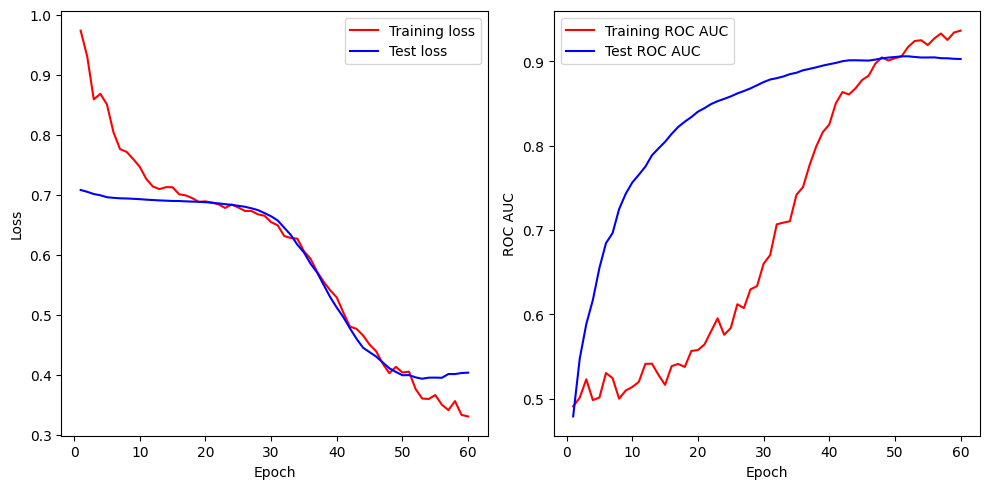

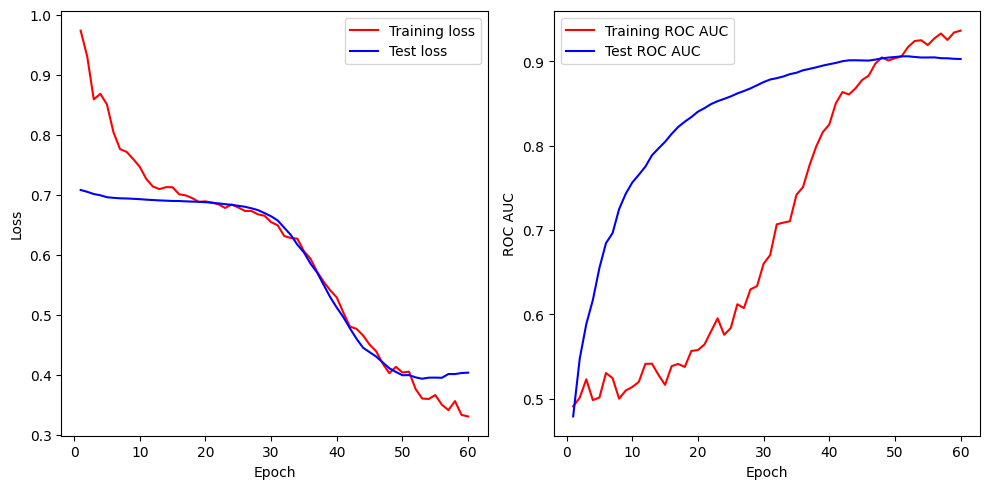

In [ ]:
auc_history = {'train': [], 'test': []}
aucs = {'train': [], 'test': []}
loss_history = {'train': [], 'test': []}
losses = {'train': [], 'test': []}

for epoch in tqdm(range(60)):
    for i, (x_batch, y_batch) in enumerate(train_loader):
        model.train()
        # forward pass
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        pred = model(x_batch)
        loss = criterion(pred, y_batch)
        losses['train'].append(np.mean(loss.detach().cpu().numpy()))
        aucs['train'].append(np.mean(roc_auc_score(
            y_batch.detach().cpu().numpy(), pred.detach().cpu().numpy())))
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # check performance on test
        model.eval()
        with torch.no_grad():
            test_example = iter(test_loader)
            x_test, y_test = next(test_example)
            x_test = x_test.to(device)
            y_test = y_test.to(device)
            pred_test = model(x_test)
            loss = criterion(pred_test, y_test)
            losses['test'].append(np.mean(loss.detach().cpu().numpy()))
            aucs['test'].append(np.mean(roc_auc_score(
                y_test.detach().cpu().numpy(), pred_test.detach().cpu().numpy())))

    # plot statistics
    loss_history['train'].append(sum(losses['train'])/len(losses['train']))
    loss_history['test'].append(sum(losses['test'])/len(losses['test']))
    losses = {'train': [], 'test': []}
    auc_history['train'].append(sum(aucs['train'])/len(aucs['train']))
    auc_history['test'].append(sum(aucs['test'])/len(aucs['test']))
    aucs = {'train': [], 'test': []}

plot_stats(loss_history, auc_history)

In [ ]:
dict_metrics_eur_eur = {}

In [ ]:
# performance on the test dataset
overall_test_aucs = []
overall_pred_values = []
model.eval()
with torch.no_grad():
    for x_test, y_test in test_loader:
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        pred_test = model(x_test)
        overall_pred_values.append(pred_test)
        overall_test_aucs.append(np.mean(roc_auc_score(
            y_test.detach().cpu().numpy(), pred_test.detach().cpu().numpy())))

Model_ROC_AUC = sum(overall_test_aucs)/len(overall_test_aucs)
print('ROC-AUC = ', Model_ROC_AUC)

ROC-AUC =  0.8937903522864491


In [ ]:
all_preds = []
for el in overall_pred_values:
  el = el.to('cpu')
  el = el.detach().numpy()
  for k in el:
    all_preds.append(round(k[0]))

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_dataset.y_data.numpy().ravel(), all_preds, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.85      0.78      0.81       657
           1       0.78      0.84      0.81       592

    accuracy                           0.81      1249
   macro avg       0.81      0.81      0.81      1249
weighted avg       0.81      0.81      0.81      1249



In [ ]:
dict_metrics_eur_eur['roc_mlp'] = Model_ROC_AUC
dict_metrics_eur_eur['accuracy_mlp'] = accuracy_score(test_dataset.y_data.numpy().ravel(), all_preds)
dict_metrics_eur_eur['recall_mlp'] = recall_score(test_dataset.y_data.numpy().ravel(), all_preds, average='weighted')
dict_metrics_eur_eur['precision_mlp'] = precision_score(test_dataset.y_data.numpy().ravel(), all_preds, average='weighted')
dict_metrics_eur_eur['f1_mlp'] = f1_score(test_dataset.y_data.numpy().ravel(), all_preds, average='weighted')

CNN

In [ ]:
class CNN(nn.Module):
    def __init__(self, input_size, batch_size=512, bn_momentum=0.9, drop=(0.9, 0.9)):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=1000, kernel_size=1, stride=1)
        self.conv2 = nn.Conv1d(in_channels=1000, out_channels=500, kernel_size=1, stride=1)
        #self.conv3 = nn.Conv1d(in_channels=500, out_channels=500, kernel_size=1, stride=1)
        self.lin1 = nn.Linear(500, 250)
        self.lin2 = nn.Linear(250, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        self.dropout_first = nn.Dropout(p=drop[0])
        self.dropout_other = nn.Dropout(p=drop[1])

    def forward(self, X):
        X = torch.unsqueeze(X, 1)
        X = X.transpose(1, 2)
        x_cnn1 = self.conv1(X)
        x_cnn2 = self.conv2(x_cnn1)
        #x_cnn3 = self.conv3(x_cnn2)
        X = torch.squeeze(x_cnn2)

        X = self.dropout_first(X)
        X = self.lin1(X)

        X = self.relu(X)
        X = self.lin2(X)
        X = self.sigmoid(X)

        return X

In [ ]:
model = CNN(1555, batch_size=batch_size, bn_momentum=0.9,
           drop=(0.9, 0.9)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCELoss()

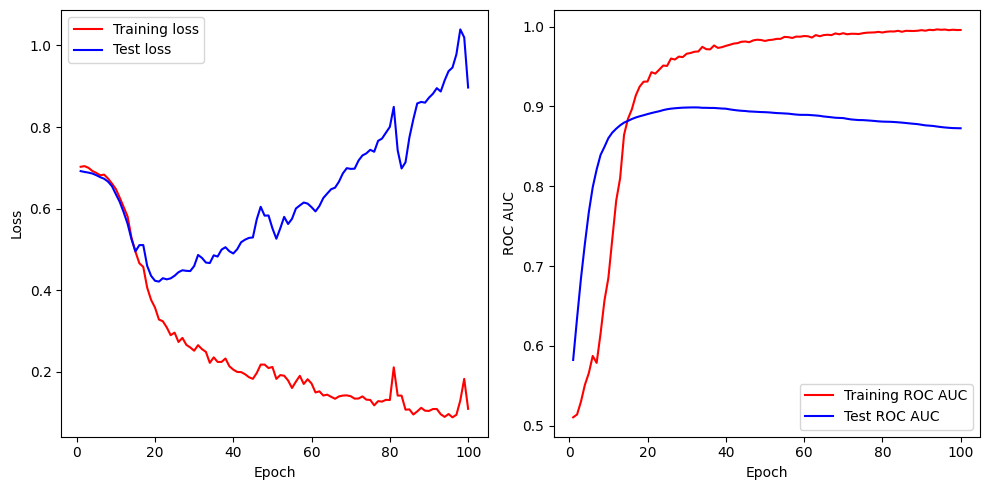

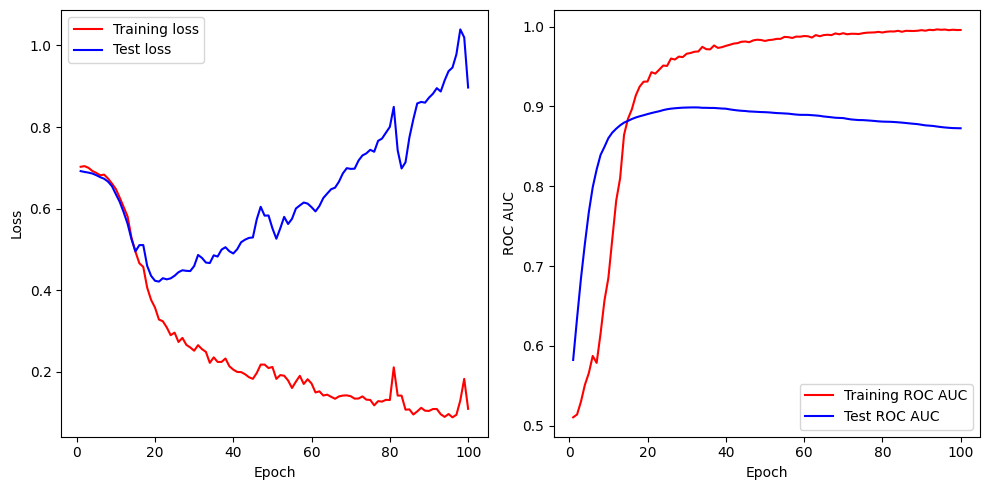

In [ ]:
auc_history = {'train': [], 'test': []}
aucs = {'train': [], 'test': []}
loss_history = {'train': [], 'test': []}
losses = {'train': [], 'test': []}

for epoch in tqdm(range(60)):
    for i, (x_batch, y_batch) in enumerate(train_loader):
        model.train()
        # forward pass
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        pred = model(x_batch)
        loss = criterion(pred, y_batch)
        losses['train'].append(np.mean(loss.detach().cpu().numpy()))
        aucs['train'].append(np.mean(roc_auc_score(
            y_batch.detach().cpu().numpy(), pred.detach().cpu().numpy())))
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # check performance on test
        model.eval()
        with torch.no_grad():
            test_example = iter(test_loader)
            x_test, y_test = next(test_example)
            x_test = x_test.to(device)
            y_test = y_test.to(device)
            pred_test = model(x_test)
            loss = criterion(pred_test, y_test)
            losses['test'].append(np.mean(loss.detach().cpu().numpy()))
            aucs['test'].append(np.mean(roc_auc_score(
                y_test.detach().cpu().numpy(), pred_test.detach().cpu().numpy())))

    # plot statistics
    loss_history['train'].append(sum(losses['train'])/len(losses['train']))
    loss_history['test'].append(sum(losses['test'])/len(losses['test']))
    losses = {'train': [], 'test': []}
    auc_history['train'].append(sum(aucs['train'])/len(aucs['train']))
    auc_history['test'].append(sum(aucs['test'])/len(aucs['test']))
    aucs = {'train': [], 'test': []}

plot_stats(loss_history, auc_history)

In [ ]:
# performance on the test dataset
overall_test_aucs = []
overall_pred_values = []
model.eval()
with torch.no_grad():
    for x_test, y_test in test_loader:
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        pred_test = model(x_test)
        overall_pred_values.append(pred_test)
        overall_test_aucs.append(np.mean(roc_auc_score(
            y_test.detach().cpu().numpy(), pred_test.detach().cpu().numpy())))

Model_ROC_AUC = sum(overall_test_aucs)/len(overall_test_aucs)

In [ ]:
print(f"Model ROC AUC: {Model_ROC_AUC:.3}")

Model ROC AUC: 0.865


In [ ]:
all_preds = []
for el in overall_pred_values:
  el = el.to('cpu')
  el = el.detach().numpy()
  for k in el:
    all_preds.append(round(k[0]))


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_dataset.y_data.numpy().ravel(), all_preds, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.82      0.75      0.78       657
           1       0.75      0.81      0.78       592

    accuracy                           0.78      1249
   macro avg       0.78      0.78      0.78      1249
weighted avg       0.78      0.78      0.78      1249



In [ ]:
dict_metrics_eur_eur['roc_cnn'] = Model_ROC_AUC
dict_metrics_eur_eur['accuracy_cnn'] = accuracy_score(test_dataset.y_data.numpy().ravel(), all_preds)
dict_metrics_eur_eur['recall_cnn'] = recall_score(test_dataset.y_data.numpy().ravel(), all_preds, average='weighted')
dict_metrics_eur_eur['precision_cnn'] = precision_score(test_dataset.y_data.numpy().ravel(), all_preds, average='weighted')
dict_metrics_eur_eur['f1_cnn'] = f1_score(test_dataset.y_data.numpy().ravel(), all_preds, average='weighted')

RNN

In [ ]:
class LSTMClassification(nn.Module):

    def __init__(self, input_dim, hidden_dim, target_size):
        super(LSTMClassification, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, target_size)
        self.hidden_dim = hidden_dim
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_):
        input_ = input_.unsqueeze(dim=1)
        lstm_out, (h, c) = self.lstm(input_)
        lstm_out = lstm_out.view(-1, self.hidden_dim)
        logits = self.fc(lstm_out)
        scores = self.sigmoid(logits)
        return scores


In [ ]:
input_dim = 1555 # здесь ввести input_dim в зависимости от x_data
hidden_dim = round(input_dim/2)

In [ ]:
model = LSTMClassification(input_dim=input_dim, hidden_dim=hidden_dim, target_size=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCELoss()

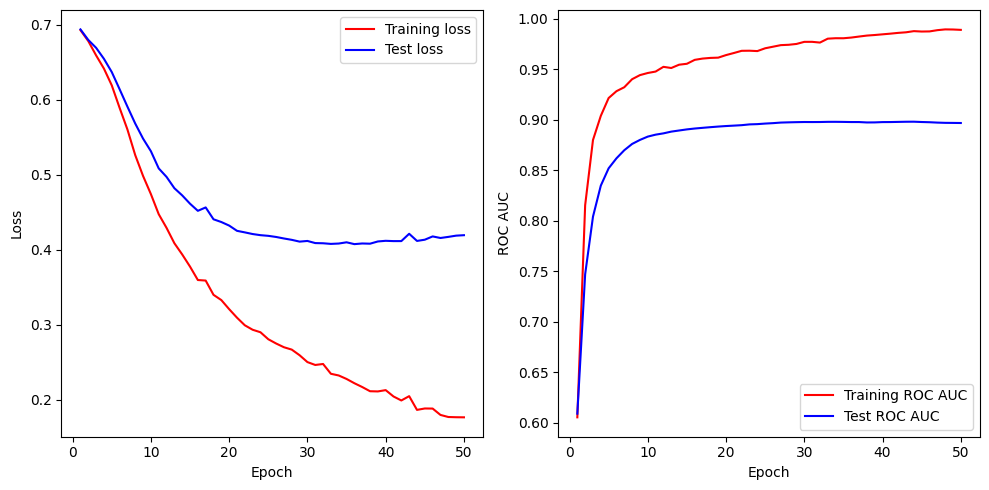

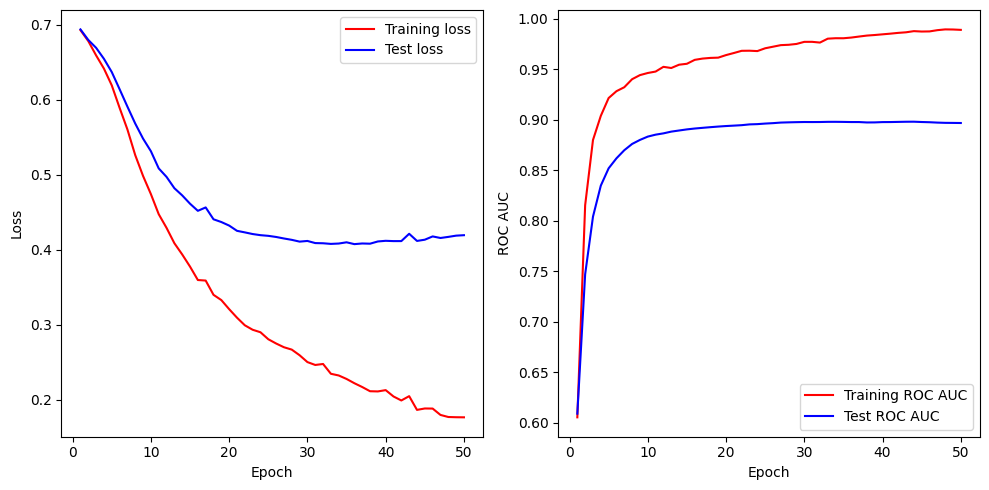

In [ ]:
auc_history = {'train': [], 'test': []}
aucs = {'train': [], 'test': []}
loss_history = {'train': [], 'test': []}
losses = {'train': [], 'test': []}

for epoch in tqdm(range(50)):
    for i, (x_batch, y_batch) in enumerate(train_loader):
        model.train()
        # forward pass
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        pred = model(x_batch)
        loss = criterion(pred, y_batch)
        losses['train'].append(np.mean(loss.detach().cpu().numpy()))
        aucs['train'].append(np.mean(roc_auc_score(
            y_batch.detach().cpu().numpy(), pred.detach().cpu().numpy())))
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # check performance on test
        model.eval()
        with torch.no_grad():
            test_example = iter(test_loader)
            x_test, y_test = next(test_example)
            x_test = x_test.to(device)
            y_test = y_test.to(device)
            pred_test = model(x_test)
            loss = criterion(pred_test, y_test)
            losses['test'].append(np.mean(loss.detach().cpu().numpy()))
            aucs['test'].append(np.mean(roc_auc_score(
                y_test.detach().cpu().numpy(), pred_test.detach().cpu().numpy())))

    # plot statistics
    loss_history['train'].append(sum(losses['train'])/len(losses['train']))
    loss_history['test'].append(sum(losses['test'])/len(losses['test']))
    losses = {'train': [], 'test': []}
    auc_history['train'].append(sum(aucs['train'])/len(aucs['train']))
    auc_history['test'].append(sum(aucs['test'])/len(aucs['test']))
    aucs = {'train': [], 'test': []}

plot_stats(loss_history, auc_history)

In [ ]:
# performance on the test dataset
overall_test_aucs = []
overall_pred_values = []
model.eval()
with torch.no_grad():
    for x_test, y_test in test_loader:
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        pred_test = model(x_test)
        overall_pred_values.append(pred_test)
        overall_test_aucs.append(np.mean(roc_auc_score(
            y_test.detach().cpu().numpy(), pred_test.detach().cpu().numpy())))

Model_ROC_AUC = sum(overall_test_aucs)/len(overall_test_aucs)

In [ ]:
print(f"Model ROC AUC: {Model_ROC_AUC:.3}")

Model ROC AUC: 0.889


In [ ]:
all_preds = []
for el in overall_pred_values:
  el = el.to('cpu')
  el = el.detach().numpy()
  for k in el:
    all_preds.append(round(k[0]))

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_dataset.y_data.numpy().ravel(), all_preds, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.85      0.77      0.81       657
           1       0.77      0.85      0.81       592

    accuracy                           0.81      1249
   macro avg       0.81      0.81      0.81      1249
weighted avg       0.81      0.81      0.81      1249



In [ ]:
dict_metrics_eur_eur['roc_rnn'] = Model_ROC_AUC
dict_metrics_eur_eur['accuracy_rnn'] = accuracy_score(test_dataset.y_data.numpy().ravel(), all_preds)
dict_metrics_eur_eur['recall_rnn'] = recall_score(test_dataset.y_data.numpy().ravel(), all_preds, average='weighted')
dict_metrics_eur_eur['precision_rnn'] = precision_score(test_dataset.y_data.numpy().ravel(), all_preds, average='weighted')
dict_metrics_eur_eur['f1_rnn'] = f1_score(test_dataset.y_data.numpy().ravel(), all_preds, average='weighted')

CNN + RNN

In [ ]:
class RNN_CNN(nn.Module):
    def __init__(self, input_size, batch_size=512, bn_momentum=0.9, drop=0.9):
        super(RNN_CNN, self).__init__()

        self.lstm = nn.LSTM(input_size, 500, batch_first=True, bidirectional=True)

        self.conv1 = nn.Conv1d(in_channels=1000, out_channels=2000, kernel_size=1, stride=1)
        self.conv2 = nn.Conv1d(in_channels=2000, out_channels=500, kernel_size=1, stride=1)

        self.lin2 = nn.Linear(500, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        self.dropout_first = nn.Dropout(p=drop)
        self.dropout_other = nn.Dropout(p=drop)

    def forward(self, X):
        X = torch.unsqueeze(X, 1)
        lstm_out, (h, c) = self.lstm(X)
        X = self.dropout_first(lstm_out)
        X = X.transpose(1, 2)

        x_cnn1 = self.conv1(X)
        x_cnn2 = self.conv2(x_cnn1)
        X = torch.squeeze(x_cnn2)

        X = self.relu(X)
        X = self.lin2(X)
        X = self.sigmoid(X)

        return X

In [ ]:
input_size = 1555

In [ ]:
model = RNN_CNN(input_size, batch_size=batch_size, bn_momentum=0.9,
           drop=0.9).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

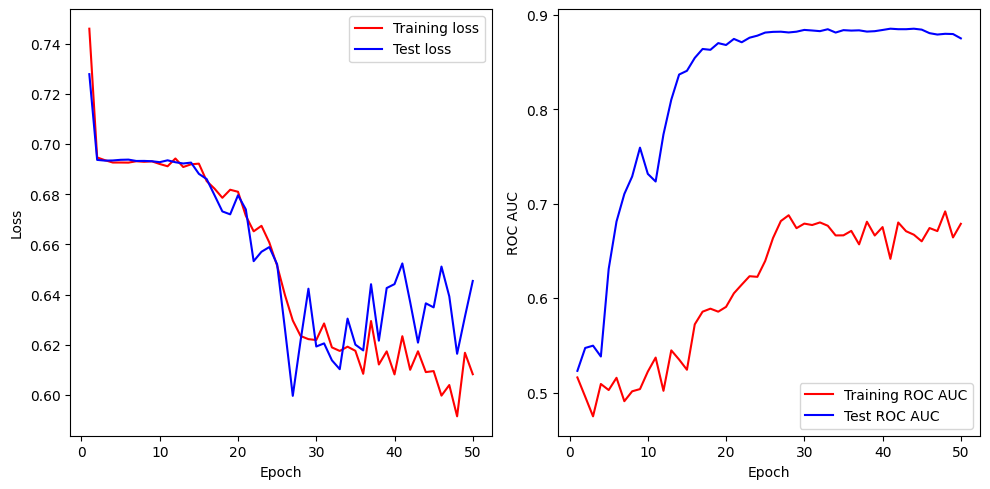

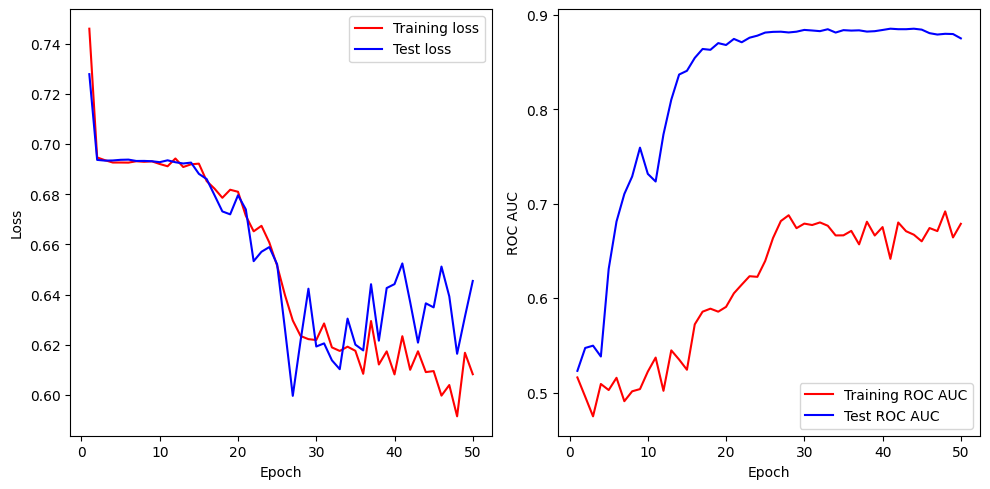

In [ ]:
auc_history = {'train': [], 'test': []}
aucs = {'train': [], 'test': []}
loss_history = {'train': [], 'test': []}
losses = {'train': [], 'test': []}

for epoch in tqdm(range(50)):
    for i, (x_batch, y_batch) in enumerate(train_loader):
        model.train()
        # forward pass
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        pred = model(x_batch)
        loss = criterion(pred, y_batch)
        losses['train'].append(np.mean(loss.detach().cpu().numpy()))
        aucs['train'].append(np.mean(roc_auc_score(
            y_batch.detach().cpu().numpy(), pred.detach().cpu().numpy())))
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # check performance on test
        model.eval()
        with torch.no_grad():
            test_example = iter(test_loader)
            x_test, y_test = next(test_example)
            x_test = x_test.to(device)
            y_test = y_test.to(device)
            pred_test = model(x_test)
            loss = criterion(pred_test, y_test)
            losses['test'].append(np.mean(loss.detach().cpu().numpy()))
            aucs['test'].append(np.mean(roc_auc_score(
                y_test.detach().cpu().numpy(), pred_test.detach().cpu().numpy())))

    # plot statistics
    loss_history['train'].append(sum(losses['train'])/len(losses['train']))
    loss_history['test'].append(sum(losses['test'])/len(losses['test']))
    losses = {'train': [], 'test': []}
    auc_history['train'].append(sum(aucs['train'])/len(aucs['train']))
    auc_history['test'].append(sum(aucs['test'])/len(aucs['test']))
    aucs = {'train': [], 'test': []}
plot_stats(loss_history, auc_history)

In [ ]:
# performance on the test dataset
overall_test_aucs = []
overall_pred_values = []
model.eval()
with torch.no_grad():
    for x_test, y_test in test_loader:
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        pred_test = model(x_test)
        overall_pred_values.append(pred_test)
        overall_test_aucs.append(np.mean(roc_auc_score(
            y_test.detach().cpu().numpy(), pred_test.detach().cpu().numpy())))

Model_ROC_AUC = sum(overall_test_aucs)/len(overall_test_aucs)

In [ ]:
all_preds = []
for el in overall_pred_values:
  el = el.to('cpu')
  el = el.detach().numpy()
  for k in el:
    all_preds.append(round(k[0]))

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_dataset.y_data.numpy().ravel(), all_preds, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.88      0.64      0.75       657
           1       0.70      0.91      0.79       592

    accuracy                           0.77      1249
   macro avg       0.79      0.78      0.77      1249
weighted avg       0.80      0.77      0.77      1249



In [ ]:
dict_metrics_eur_eur['roc_cnn_rnn'] = Model_ROC_AUC
dict_metrics_eur_eur['accuracy_cnn_rnn'] = accuracy_score(test_dataset.y_data.numpy().ravel(), all_preds)
dict_metrics_eur_eur['recall_cnn_rnn'] = recall_score(test_dataset.y_data.numpy().ravel(), all_preds, average='weighted')
dict_metrics_eur_eur['precision_cnn_rnn'] = precision_score(test_dataset.y_data.numpy().ravel(), all_preds, average='weighted')
dict_metrics_eur_eur['f1_cnn_rnn'] = f1_score(test_dataset.y_data.numpy().ravel(), all_preds, average='weighted')

### Machine Learning MODELS

Logistic Regression

In [ ]:
logreg = LogisticRegression(max_iter = 1000)
logreg.fit(train_dataset.x_data.numpy(), train_dataset.y_data.numpy().ravel())
LogReg_ROC_AUC = roc_auc_score(test_dataset.y_data.numpy().ravel(),
                    logreg.predict_proba(test_dataset.x_data.numpy())[:, 1])

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
print(classification_report(test_dataset.y_data.numpy().ravel(), logreg.predict(test_dataset.x_data.numpy())))

              precision    recall  f1-score   support

         0.0       0.79      0.74      0.76       657
         1.0       0.73      0.78      0.75       592

    accuracy                           0.76      1249
   macro avg       0.76      0.76      0.76      1249
weighted avg       0.76      0.76      0.76      1249



In [ ]:
LogReg_ROC_AUC

0.8510556789666379

In [ ]:
dict_metrics_eur_eur['roc_logreg'] = LogReg_ROC_AUC
dict_metrics_eur_eur['accuracy_logreg'] = accuracy_score(test_dataset.y_data.numpy().ravel(), logreg.predict(test_dataset.x_data.numpy()))
dict_metrics_eur_eur['recall_logreg'] = recall_score(test_dataset.y_data.numpy().ravel(), logreg.predict(test_dataset.x_data.numpy()), average='weighted')
dict_metrics_eur_eur['precision_logreg'] = precision_score(test_dataset.y_data.numpy().ravel(), logreg.predict(test_dataset.x_data.numpy()), average='weighted')
dict_metrics_eur_eur['f1_logreg'] = f1_score(test_dataset.y_data.numpy().ravel(), logreg.predict(test_dataset.x_data.numpy()), average='weighted')

Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
gbc = GradientBoostingClassifier(n_estimators=1000, learning_rate=1.0, max_depth=2, random_state=0).fit(train_dataset.x_data.numpy(), train_dataset.y_data.numpy().ravel())

In [ ]:
print(classification_report(test_dataset.y_data.numpy().ravel(), gbc.predict(test_dataset.x_data.numpy())))

              precision    recall  f1-score   support

         0.0       0.75      0.73      0.74       657
         1.0       0.71      0.74      0.72       592

    accuracy                           0.73      1249
   macro avg       0.73      0.73      0.73      1249
weighted avg       0.73      0.73      0.73      1249



In [ ]:
GB_ROC_AUC = roc_auc_score(test_dataset.y_data.numpy().ravel(),
                    gbc.predict_proba(test_dataset.x_data.numpy())[:, 1])

In [ ]:
GB_ROC_AUC

0.798076329754412

In [ ]:
dict_metrics_eur_eur['roc_gb'] = GB_ROC_AUC
dict_metrics_eur_eur['accuracy_gb'] = accuracy_score(test_dataset.y_data.numpy().ravel(), gbc.predict(test_dataset.x_data.numpy()))
dict_metrics_eur_eur['recall_gb'] = recall_score(test_dataset.y_data.numpy().ravel(), gbc.predict(test_dataset.x_data.numpy()), average='weighted')
dict_metrics_eur_eur['precision_gb'] = precision_score(test_dataset.y_data.numpy().ravel(), gbc.predict(test_dataset.x_data.numpy()), average='weighted')
dict_metrics_eur_eur['f1_gb'] = f1_score(test_dataset.y_data.numpy().ravel(), gbc.predict(test_dataset.x_data.numpy()), average='weighted')

Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf_clf = RandomForestClassifier(max_depth=100, random_state=0)
rf_clf.fit(train_dataset.x_data.numpy(), train_dataset.y_data.numpy().ravel())

RandomForestClassifier(max_depth=100, random_state=0)

In [ ]:
print(classification_report(test_dataset.y_data.numpy().ravel(), rf_clf.predict(test_dataset.x_data.numpy())))

              precision    recall  f1-score   support

         0.0       0.61      0.52      0.56       657
         1.0       0.54      0.63      0.58       592

    accuracy                           0.57      1249
   macro avg       0.58      0.58      0.57      1249
weighted avg       0.58      0.57      0.57      1249



In [ ]:
RF_ROC_AUC = roc_auc_score(test_dataset.y_data.numpy().ravel(),
                    rf_clf.predict_proba(test_dataset.x_data.numpy())[:, 1])

In [ ]:
RF_ROC_AUC

0.6052735098111811

In [ ]:
dict_metrics_eur_eur['roc_rf'] = RF_ROC_AUC
dict_metrics_eur_eur['accuracy_rf'] = accuracy_score(test_dataset.y_data.numpy().ravel(), rf_clf.predict(test_dataset.x_data.numpy()))
dict_metrics_eur_eur['recall_rf'] = recall_score(test_dataset.y_data.numpy().ravel(), rf_clf.predict(test_dataset.x_data.numpy()), average='weighted')
dict_metrics_eur_eur['precision_rf'] = precision_score(test_dataset.y_data.numpy().ravel(), rf_clf.predict(test_dataset.x_data.numpy()), average='weighted')
dict_metrics_eur_eur['f1_rf'] = f1_score(test_dataset.y_data.numpy().ravel(), rf_clf.predict(test_dataset.x_data.numpy()), average='weighted')

SVM

In [ ]:
from sklearn import svm

In [ ]:
svm_clf = svm.SVC(probability=True)
svm_clf.fit(train_dataset.x_data.numpy(), train_dataset.y_data.numpy().ravel())

SVC(probability=True)

In [ ]:
print(classification_report(test_dataset.y_data.numpy().ravel(), svm_clf.predict(test_dataset.x_data.numpy())))

              precision    recall  f1-score   support

         0.0       0.84      0.79      0.82       657
         1.0       0.78      0.83      0.81       592

    accuracy                           0.81      1249
   macro avg       0.81      0.81      0.81      1249
weighted avg       0.81      0.81      0.81      1249



In [ ]:
SVM_ROC_AUC = roc_auc_score(test_dataset.y_data.numpy().ravel(),
                    svm_clf.predict_proba(test_dataset.x_data.numpy())[:, 1])

In [ ]:
SVM_ROC_AUC

0.8898684643547656

In [ ]:
dict_metrics_eur_eur['roc_svm'] = SVM_ROC_AUC
dict_metrics_eur_eur['accuracy_svm'] = accuracy_score(test_dataset.y_data.numpy().ravel(), svm_clf.predict(test_dataset.x_data.numpy()))
dict_metrics_eur_eur['recall_svm'] = recall_score(test_dataset.y_data.numpy().ravel(), svm_clf.predict(test_dataset.x_data.numpy()), average='weighted')
dict_metrics_eur_eur['precision_svm'] = precision_score(test_dataset.y_data.numpy().ravel(), svm_clf.predict(test_dataset.x_data.numpy()), average='weighted')
dict_metrics_eur_eur['f1_svm'] = f1_score(test_dataset.y_data.numpy().ravel(), svm_clf.predict(test_dataset.x_data.numpy()), average='weighted')

Desicion Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
dt_clf = DecisionTreeClassifier(max_depth=100)
dt_clf.fit(train_dataset.x_data.numpy(), train_dataset.y_data.numpy().ravel())

In [ ]:
print(classification_report(test_dataset.y_data.numpy().ravel(), dt_clf.predict(test_dataset.x_data.numpy())))

In [ ]:
DT_ROC_AUC = roc_auc_score(test_dataset.y_data.numpy().ravel(),
                    dt_clf.predict_proba(test_dataset.x_data.numpy())[:, 1])

In [ ]:
DT_ROC_AUC

In [ ]:
dict_metrics_eur_eur['roc_dt'] = DT_ROC_AUC
dict_metrics_eur_eur['accuracy_dt'] = accuracy_score(test_dataset.y_data.numpy().ravel(), dt_clf.predict(test_dataset.x_data.numpy()))
dict_metrics_eur_eur['recall_dt'] = recall_score(test_dataset.y_data.numpy().ravel(), dt_clf.predict(test_dataset.x_data.numpy()), average='weighted')
dict_metrics_eur_eur['precision_dt'] = precision_score(test_dataset.y_data.numpy().ravel(), dt_clf.predict(test_dataset.x_data.numpy()), average='weighted')
dict_metrics_eur_eur['f1_dt'] = f1_score(test_dataset.y_data.numpy().ravel(), dt_clf.predict(test_dataset.x_data.numpy()), average='weighted')

In [ ]:
dict_metrics_eur_eur